# Homework 6 - Datasets


## Exercise 1

Objective:
Implement a dataset class for the custom dataset: https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection

Note, that this dataset contains object detection annotations in the form of xml files. Object detection annotations are a way to describe the location (bounding box) in addition to the class of objects in an image.

The task is to:

1. Download the dataset locally
2. Pass the path to the test folder to the `root_dir` parameter of the `CustomDataset` constructor method.
3. Complete the methods of the `CustomDataset` class, so that it can be used to load the data.
4. Introduce all the sensible transformations to the dataset, including four new transformations that were not used during the lecture. Feel free to use `albumentations` or `torchvision.transforms.v2`. Try to apply point transformations to images, such that the
labels remain valid after transformation has been applied.

Hint: To read the xml files, you can use the `xml.etree.ElementTree` module.

```

Objects after transformation: [[62.22222137451172, 67.1288833618164, 154.66665649414062, 185.45777893066406], [9.777777671813965, 23.893333435058594, 92.44444274902344, 125.15555572509766], [118.22222137451172, 25.031110763549805, 215.11111450195312, 129.7066650390625], [94.22222137451172, 142.22222900390625, 191.11111450195312, 256.0], [183.11111450195312, 155.87554931640625, 256.0, 256.0]]
(tensor([[[0.7020, 0.7020, 0.6667,  ..., 0.2745, 0.2745, 0.4667],
         [0.7020, 0.7020, 0.6667,  ..., 0.2745, 0.2745, 0.4667],
         [0.7020, 0.7020, 0.6667,  ..., 0.2745, 0.2745, 0.4667],
         ...,
         [0.2471, 0.2471, 0.2392,  ..., 0.0000, 0.0000, 0.3922],
         [0.2392, 0.2392, 0.2510,  ..., 0.0000, 0.0000, 0.3529],
         [0.2157, 0.2157, 0.2941,  ..., 0.0039, 0.0039, 0.1804]],

        [[0.7922, 0.7922, 0.7569,  ..., 0.2824, 0.2824, 0.5451],
         [0.7922, 0.7922, 0.7569,  ..., 0.2824, 0.2824, 0.5451],
         [0.7922, 0.7922, 0.7569,  ..., 0.2824, 0.2824, 0.5451],
   

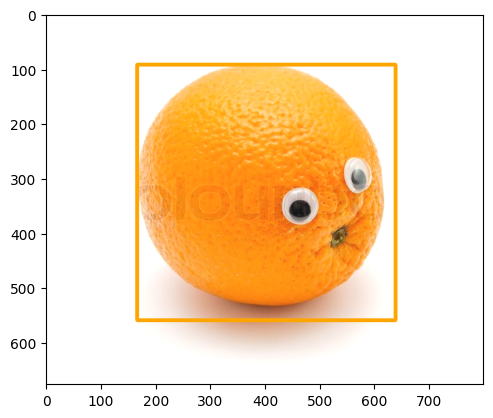

Objects after transformation: [[72.99998474121094, 227.0, 511.0, 723.0]]


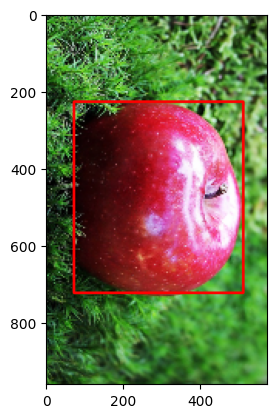

Objects after transformation: [[85.00000762939453, 6.999993324279785, 412.0, 359.0]]


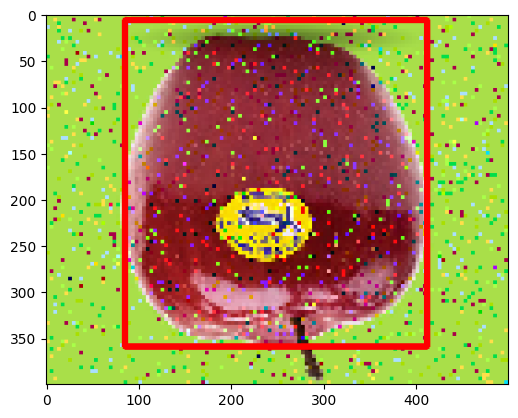

Objects after transformation: [[55.80224609375, 36.08053970336914, 217.45619201660156, 108.24161529541016], [52.92584228515625, 159.78524780273438, 216.8809051513672, 231.37359619140625]]


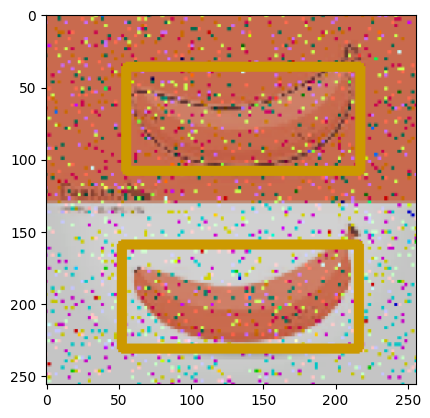

Objects after transformation: [[75.0, 111.0, 301.0, 372.0]]


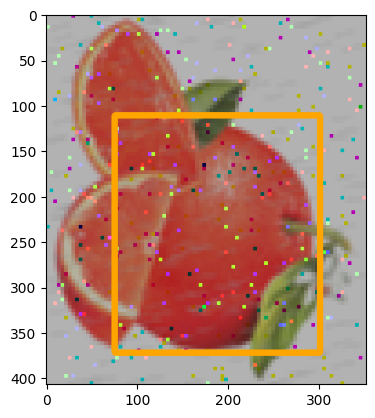

Objects after transformation: [[228.0, 83.0, 401.0, 270.0], [43.0, 74.0, 183.0, 244.0], [128.0, 56.0, 282.0, 221.0]]


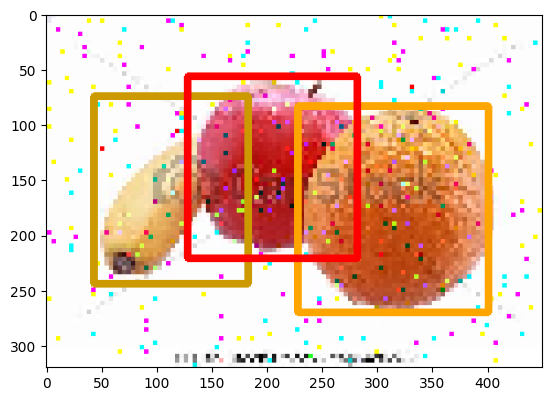

Objects after transformation: [[6.335210800170898, 54.50074768066406, 233.53880310058594, 192.67166137695312]]


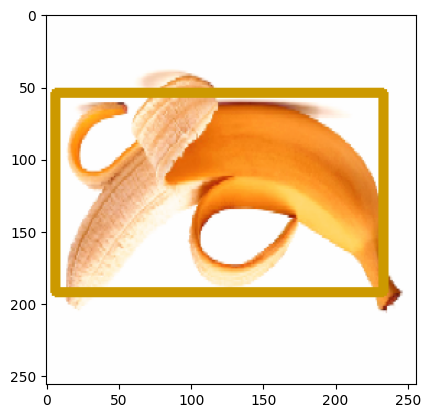

Objects after transformation: [[117.91515350341797, 28.11560821533203, 232.72727966308594, 253.04046630859375], [55.07878875732422, 2.9595377445220947, 162.90908813476562, 248.6011505126953]]


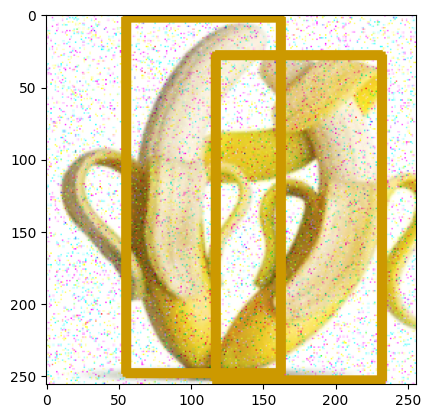

Objects after transformation: [[123.0, 602.0, 299.0, 731.0], [1.0, 174.00001525878906, 143.99998474121094, 353.0]]


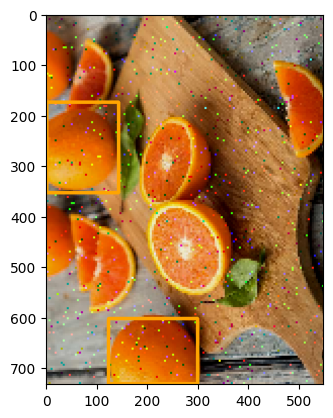

Objects after transformation: [[64.0, 113.02642059326172, 187.25926208496094, 213.4943389892578], [18.962963104248047, 180.64906311035156, 124.44444274902344, 256.0], [20.148147583007812, 47.33584976196289, 129.1851806640625, 152.63397216796875], [142.22222900390625, 73.41886138916016, 256.0, 178.71697998046875], [156.44444274902344, 0.0, 256.0, 82.11320495605469]]


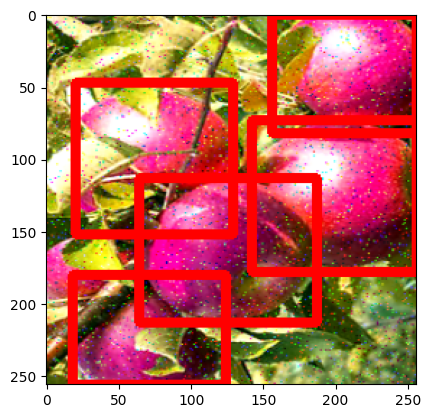

Objects after transformation: [[313.0, 228.0, 935.0, 1864.0], [401.0, 129.0, 1078.0, 1890.0], [135.0, 291.0, 642.0, 1747.0]]


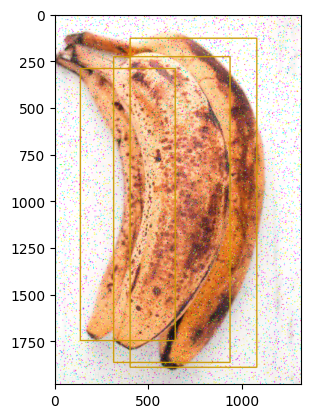

In [65]:
from torch.utils.data import Dataset, DataLoader
import torch
import cv2

from PIL import Image
from xml.etree import ElementTree as ET
from torchvision.transforms.v2 import ToTensor
import numpy as np
import matplotlib.pyplot as plt

#student imports
import os
import xml.etree.ElementTree as ET
import torchvision
import albumentations as A


class CustomDataset(Dataset):
    def __init__(self, root_dir: str, transform=None):
        """
        Properly initialize the dataset. This means filling the lists
        self.images and self.labels with paths to the images and labels, respectively.
        Note: the order of the paths in those lists is important, so use the same order
        (e.g. image orange_90.jpg and label orange_90.xml should be in the same index in the lists).
        """
        self.transform = transform
        # <your_code_here>
        self.root_dir = root_dir
        #we know that the images and labels files are in the same order so we can sort them to ensure that image and corresponding label are in the same index
        files_in_root_dir = os.listdir(self.root_dir)
        self.images = sorted([f for f in files_in_root_dir if f.endswith(".jpg")])
        self.labels = sorted([f for f in files_in_root_dir if f.endswith(".xml")])
        # </your_code_here>
    def __len__(self):
        """
        Return the number of samples in the dataset.
        """
        # <your_code_here>
        return len(self.images)
        # </your_code_here>

    def __getitem__(self, idx):
        """
        Make sure that this method returns a tuple of image and objects where:
        - image is a torch tensor of shape (C, H, W) - [channels, height, width]
        - objects is a list of tuples in the form (xmin, ymin, xmax, ymax, label).
            In other words, each image can contain multiple objects, and each object has
            bounding box data (xmin, ymin, xmax, ymax) and label.
        Note: reading xml files is a bit tricky, feel free to collaborate with your peers
        """
        # <your_code_here>
        # get rectangles of objects from xml file
        label_path = os.path.join(self.root_dir, self.labels[idx])
        tree = ET.parse(label_path)
        root = tree.getroot()
        objects: list[list[int, int, int, int]] = []
        labels: list[str] = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            box = obj.find('bndbox')
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            objects.append([xmin, ymin, xmax, ymax])
            labels.append(label)
        # get image and apply transformations
        image_path = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(image_path)
        image = np.array(image)
        if self.transform:
            image = self.transform(image=image, bboxes=objects, labels=labels)
            objects = image['bboxes']
            image = image['image']
            print("Objects after transformation:", objects)
        if type(image) != torch.Tensor:
            image = ToTensor()(image)

        objects = [(*obj, labels[i]) for i, obj in enumerate(objects)]
        # </your_code_here>
        return image, objects


"""
Change the custom_transform variable to the transformation you want to apply to the dataset.
Hint: Use torchvision.transformers.v2.Compose to combine multiple transformations.
"""
# </your_code_here>

custom_transform = A.Compose([
    # apply only point transformations
    A.ColorJitter(saturation=0.2, hue=0.1),
    A.GaussianBlur(blur_limit=3, sigma_limit=(0.1, 2.0)),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
    A.RandomRain(p=0.2),
    A.SaltAndPepper(p=0.5),
    A.Downscale(0.5),

    #apply spatial transformations
    A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.5),
    A.RandomRotate90(p=0.5),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
# </your_code_here>

"""
Change the root_dir variable to the path to the test folder.
"""
# <your_code_here>
root_dir = "data/test"
# </your_code_here>

dataset = CustomDataset(
    root_dir=root_dir,
    transform=ToTensor() if custom_transform is None else custom_transform,
)
print(dataset[0])
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

label_2_colour = {
    "orange": (255, 165, 0),
    "banana": (204, 153, 0),
    "apple": (255, 0, 0),
}

for i, (image, objects) in enumerate(dataloader):
    # image is a tensor of shape (1, 3, H, W)
    # we need to convert it to shape (H, W, 3), and then convert from torch to numpy
    img = image[0].permute(1, 2, 0).numpy()
    # change the img to that it can be displayed with opencv
    img = (img * 255).astype(np.uint8)
    for obj in objects:
        # iterate over the objects and draw bounding boxes around them
        xmin, ymin, xmax, ymax, label = obj
        color = label_2_colour[label[0]]
        img_copy = img.copy()  # Create a copy of the image
        cv2.rectangle(
            img_copy, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 5
        )
        img = img_copy  # Assign the modified copy back to img
    plt.imshow(img)
    plt.show()
    if i == 10:
        break
